In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
After attention, we need position-wise processing.
Feed-forward = simple 2-layer MLP applied to each position independently.

FFN(x) = ReLU(xW1 + b1)W2 + b2

Typical: d_model (512) → d_ff (2048) → d_model (512)
That 4x expansion is standard in transformers.
"""

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Test
d_model = 512
d_ff = 2048
x = torch.randn(2, 10, d_model)

ff = FeedForward(d_model, d_ff)
output = ff(x)

print(f"Input: {x.shape}")
print(f"Output: {output.shape}")
print(f"Hidden expansion: {d_model} → {d_ff} → {d_model}")
print("✅ Feed-forward working")

Input: torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])
Hidden expansion: 512 → 2048 → 512
✅ Feed-forward working


In [2]:
"""
Layer norm stabilizes training by normalizing across features.
Different from batch norm (which normalizes across batch).
"""

# PyTorch has it built-in, but let's understand it
class SimpleLayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        normalized = (x - mean) / (std + self.eps)
        return self.gamma * normalized + self.beta

# Test
x = torch.randn(2, 10, 512)
ln = SimpleLayerNorm(512)
output = ln(x)

print(f"Before - mean: {x.mean(dim=-1)[0,0]:.4f}, std: {x.std(dim=-1)[0,0]:.4f}")
print(f"After  - mean: {output.mean(dim=-1)[0,0]:.4f}, std: {output.std(dim=-1)[0,0]:.4f}")
print("✅ Layer norm working (mean≈0, std≈1)")

Before - mean: -0.0106, std: 1.0192
After  - mean: -0.0000, std: 1.0000
✅ Layer norm working (mean≈0, std≈1)


In [3]:
# Import your multi-head attention from Day 2
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def split_heads(self, x):
        batch, seq_len, d_model = x.size()
        x = x.view(batch, seq_len, self.num_heads, self.d_k)
        return x.transpose(1, 2)
    
    def combine_heads(self, x):
        batch, heads, seq_len, d_k = x.size()
        x = x.transpose(1, 2)
        return x.contiguous().view(batch, seq_len, self.d_model)
    
    def forward(self, x, mask=None):
        Q = self.split_heads(self.W_q(x))
        K = self.split_heads(self.W_k(x))
        V = self.split_heads(self.W_v(x))
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        output = self.combine_heads(output)
        output = self.W_o(output)
        
        return output, attention_weights

# Now build the complete block
class TransformerBlock(nn.Module):
    """
    One transformer block:
    1. Multi-head attention + residual + norm
    2. Feed-forward + residual + norm
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Attention with residual connection
        attn_output, attn_weights = self.attention(x, mask)
        x = x + self.dropout1(attn_output)  # Residual
        x = self.norm1(x)                    # Layer norm
        
        # Feed-forward with residual connection
        ff_output = self.ff(x)
        x = x + self.dropout2(ff_output)    # Residual
        x = self.norm2(x)                    # Layer norm
        
        return x, attn_weights

# Test
block = TransformerBlock(d_model=512, num_heads=8, d_ff=2048)
x = torch.randn(2, 10, 512)
output, weights = block(x)

print(f"Input: {x.shape}")
print(f"Output: {output.shape}")
print(f"Parameters: {sum(p.numel() for p in block.parameters()):,}")
print("✅ Transformer block working")

Input: torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])
Parameters: 3,152,384
✅ Transformer block working


In [4]:
class TransformerEncoder(nn.Module):
    """
    Stack of N transformer blocks (like BERT, GPT)
    """
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
    def forward(self, x, mask=None):
        attention_weights_all = []
        
        for layer in self.layers:
            x, attention_weights = layer(x, mask)
            attention_weights_all.append(attention_weights)
        
        return x, attention_weights_all

# Test with 6 layers (standard transformer)
encoder = TransformerEncoder(
    num_layers=6,
    d_model=512,
    num_heads=8,
    d_ff=2048
)

x = torch.randn(2, 10, 512)
output, all_weights = encoder(x)

print(f"Input: {x.shape}")
print(f"Output: {output.shape}")
print(f"Number of layers: {len(all_weights)}")
print(f"Total parameters: {sum(p.numel() for p in encoder.parameters()):,}")
print("✅ Stacked encoder working")

Input: torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])
Number of layers: 6
Total parameters: 18,914,304
✅ Stacked encoder working


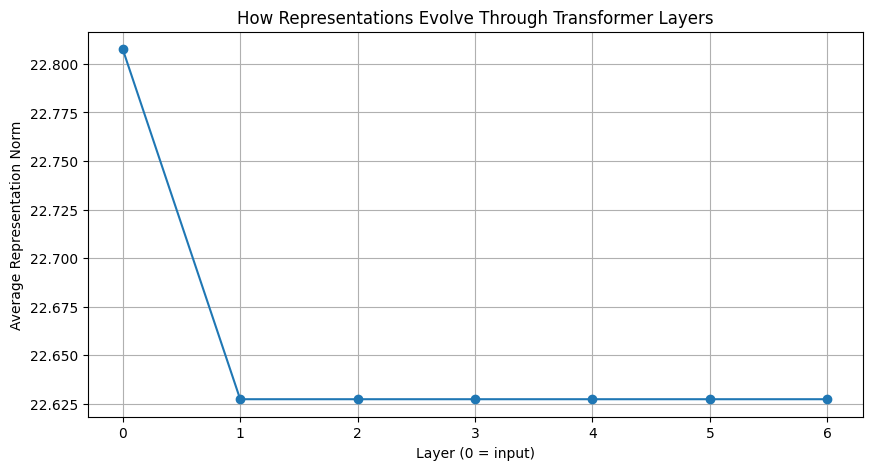

✅ Layer evolution visualized


In [5]:
# Show how representations change through layers
import matplotlib.pyplot as plt

x = torch.randn(1, 10, 512)
representations = [x]

with torch.no_grad():
    current = x
    for layer in encoder.layers:
        current, _ = layer(current)
        representations.append(current)

# Plot norm of representations at each layer
norms = [rep.norm(dim=-1).mean().item() for rep in representations]

plt.figure(figsize=(10, 5))
plt.plot(range(len(norms)), norms, marker='o')
plt.xlabel('Layer (0 = input)')
plt.ylabel('Average Representation Norm')
plt.title('How Representations Evolve Through Transformer Layers')
plt.grid(True)
plt.savefig('layer_evolution.png')
plt.show()

print("✅ Layer evolution visualized")